# **Especificamos el entorno**

In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# **Cargamos los datos**

In [3]:
# Función para eliminar la carpeta si existe y crear una nueva
def reset_data_directory(path):
  if path.exists():
    print(f"Eliminando la carpeta existente: {path}")
    shutil.rmtree(path)
  path.mkdir(parents=True, exist_ok=True)
  print(f"Creada la nueva carpeta: {path}")

In [4]:
from google.colab import drive
import shutil
from pathlib import Path

drive.mount('/content/drive')
dataset_path = Path('/content/drive/MyDrive/TFG/image_original_cifar')


Mounted at /content/drive


In [ ]:
try:
  path = untar_data(URLs.CIFAR)
except Exception as e:
  print(f"Error al descargar el dataset: {e}")

# Mover el dataset descargado a tu carpeta específica en Google Drive
if dataset_path.exists():
  shutil.rmtree(dataset_path)  # Eliminar el dataset si ya existe para actualizarlo
shutil.move(str(path), dataset_path)

Path('/content/drive/MyDrive/TFG/image_original_cifar')

### Lenet

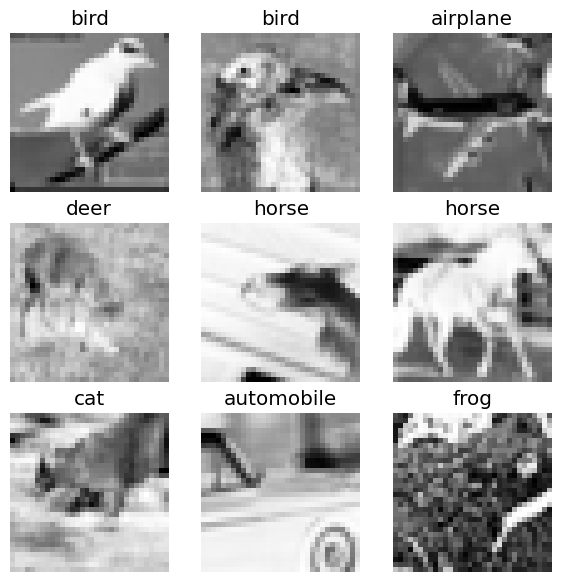

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(32),  # input original de lenet
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(dataset_path/'train', bs=256)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 40000
Número total de imágenes en validación: 10000

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 6 x 28 x 28   
Conv2d                                    156        True      
____________________________________________________________________________
                     256 x 16 x 10 x 10  
Conv2d                                    2416       True      
____________________________________________________________________________
                     256 x 16 x 5 x 5    
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 120           
Linear                                    48120      True      
____________________________________________________________________________
                     256 x 84            
Linear                                    10164      True      
___________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.295460,2.286292,0.143200,0.143674,0.078616,2:38:47
1,2.187410,2.151815,0.214900,0.216339,0.191568,03:09
2,2.028351,1.961403,0.305100,0.306200,0.282347,03:08
3,1.827156,1.778499,0.363100,0.364799,0.356743,03:10
4,1.718631,1.693673,0.394500,0.395756,0.386161,03:11
5,1.658248,1.643279,0.421600,0.422833,0.414227,03:07
6,1.602031,1.598223,0.430200,0.431506,0.425922,03:15
7,1.553683,1.569754,0.440900,0.442834,0.435828,03:09
8,1.528264,1.538956,0.455100,0.455747,0.454593,03:09
9,1.489355,1.514140,0.460900,0.461840,0.459139,03:04



Tiempo de entrenamiento: 13149.96 segundos


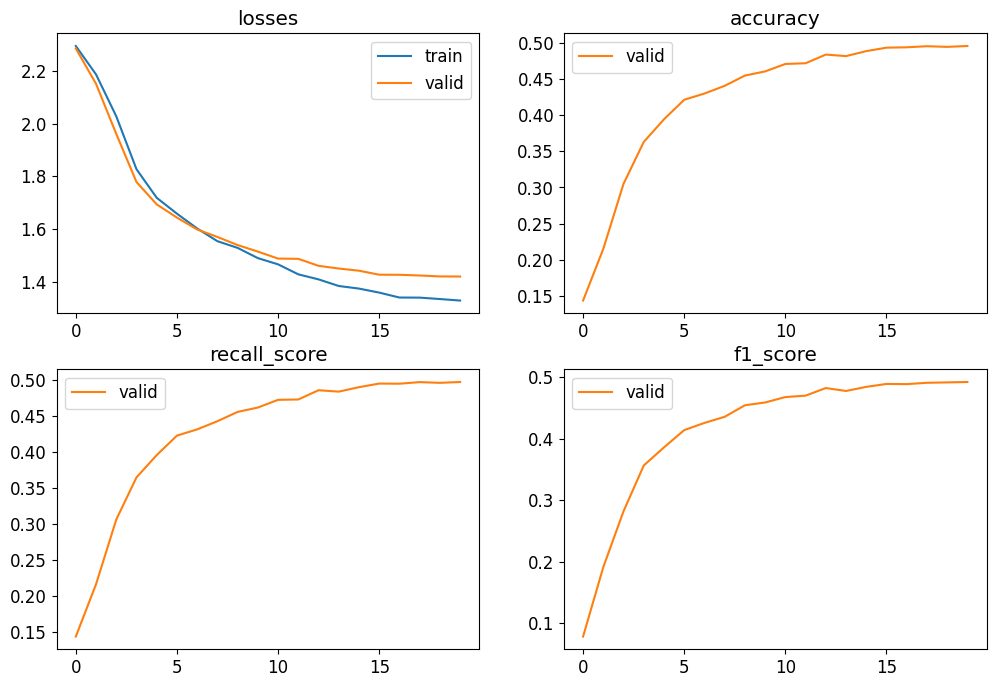

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4194
Accuracy: 0.4961
Recall: 0.4973
F1-Score: 0.4924


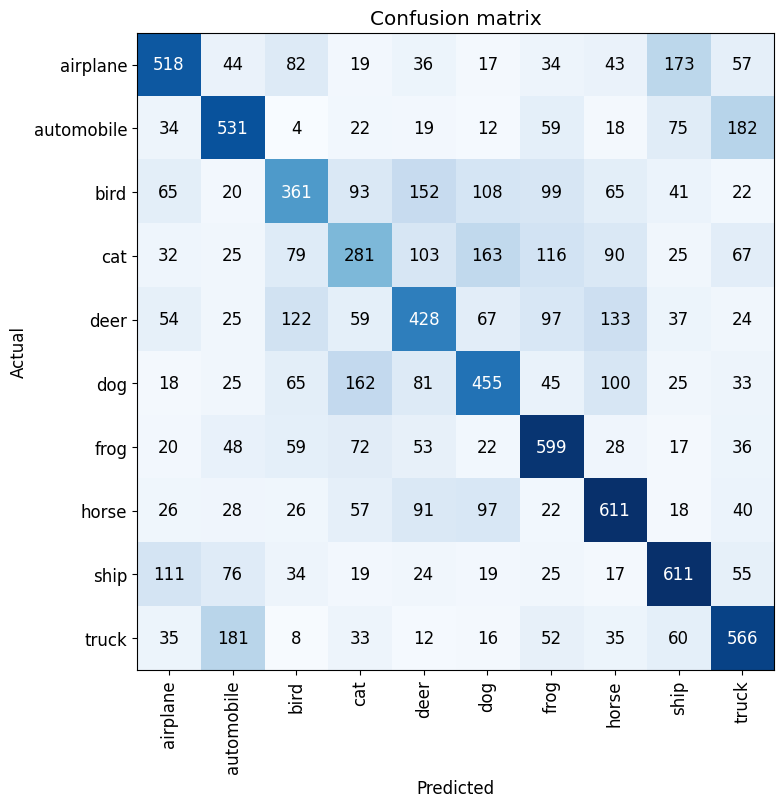

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


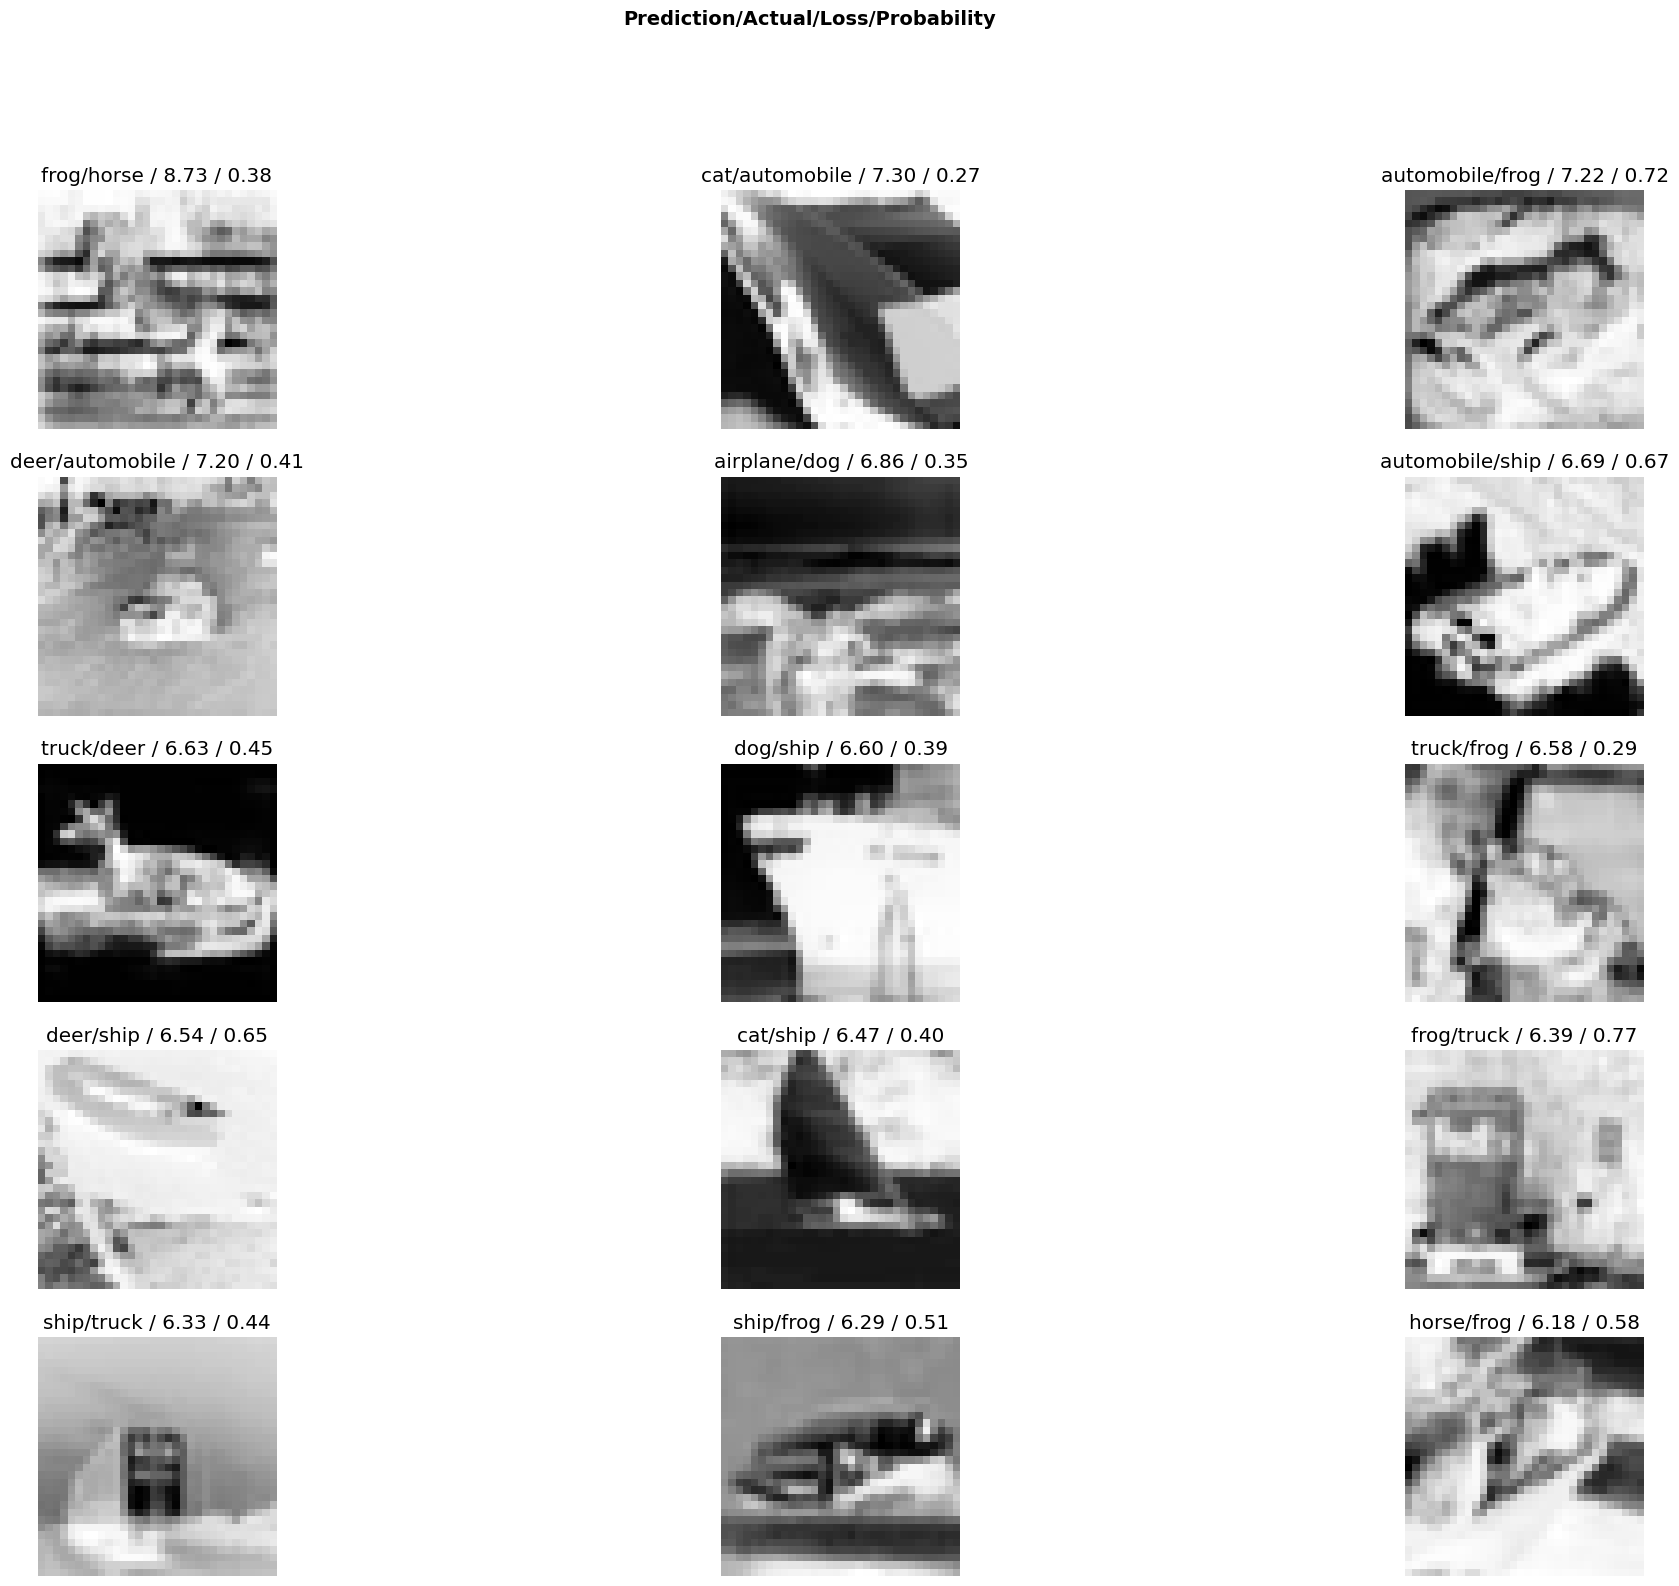

In [ ]:
interp.plot_top_losses(15, nrows=5, figsize=(25,18))

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_cifar.pkl')

### Resnet18

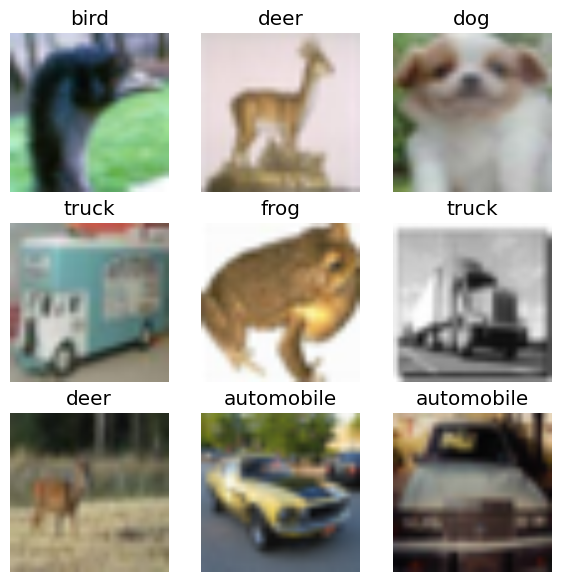

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  get_y=parent_label,
  item_tfms=Resize(224),
  splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(dataset_path/'train', bs=256)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
!ls /content/drive/MyDrive/TFG/image_original_cifar/train/

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 40000
Número total de imágenes en validación: 10000

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Para obtener el número de imágenes por clase, podemos usar Fastai con Pandas
import pandas as pd

# Crear un DataFrame con las etiquetas de entrenamiento
train_labels = pd.Series(dls.train_ds.items).apply(lambda x: Path(x).parent.name)

# Contar las ocurrencias por clase
train_counts = train_labels.value_counts().sort_index()

print("\nNúmero de imágenes por clase en entrenamiento:")
print(train_counts)

# Hacer lo mismo para el conjunto de validación
valid_labels = pd.Series(dls.valid_ds.items).apply(lambda x: Path(x).parent.name)
valid_counts = valid_labels.value_counts().sort_index()

print("\nNúmero de imágenes por clase en validación:")
print(valid_counts)


Número de imágenes por clase en entrenamiento:
airplane      3977
automobile    4044
bird          3974
cat           4019
deer          3954
dog           3991
frog          4046
horse         3984
ship          4009
truck         4002
Name: count, dtype: int64

Número de imágenes por clase en validación:
airplane      1023
automobile     956
bird          1026
cat            981
deer          1046
dog           1009
frog           954
horse         1016
ship           991
truck          998
Name: count, dtype: int64


### Original dataset - cifar

In [ ]:
from torchvision.models import resnet18

learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=True, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Sequential (Input shape: 256 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 112 x 11 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

In [ ]:
start_time = time.time()
learn.fine_tune(10)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time


In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
interp.plot_top_losses(15, nrows=5, figsize=(25,18))

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet18_cifar.pkl')

## Build Distilled dataset

In [ ]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
  avg_image = None
  count = 0

  # Recorrer cada imagen, convertirla a un array NumPy y sumarla
  for img_path in image_paths:
    with Image.open(img_path) as img:
      img = img.convert('RGB')  # Asegurarse de trabajar en RGB
      np_img = np.array(img, dtype=np.float32)
      if avg_image is None:
        avg_image = np_img
      else:
        avg_image += np_img
      count += 1

  # Calcular la media
  avg_image /= count
  avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)

  return Image.fromarray(avg_image)


In [ ]:
def create_distilled_dataset(src_path, dst_path, fraction=0.2, mix_function=media_arit):
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Si la carpeta destino existe, se elimina para crearla de nuevo
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Iterar sobre cada conjunto (por ejemplo, train, test, etc.)
    for split_dir in src_path.iterdir():
        if not split_dir.is_dir():
            continue

        split_name = split_dir.name.lower()
        new_split_dir = dst_path / split_dir.name

        if split_name == "training":
            # Procesar el conjunto de entrenamiento: destilación (mezcla) por cada clase
            new_split_dir.mkdir(parents=True, exist_ok=True)
            for class_dir in split_dir.iterdir():
                if not class_dir.is_dir():
                    continue

                # Obtener la lista de imágenes de la clase
                images = list(class_dir.glob('*.*'))
                if len(images) == 0:
                    continue

                n_images = len(images)
                new_class_dir = new_split_dir / class_dir.name
                new_class_dir.mkdir(parents=True, exist_ok=True)

                # Procesado según la fracción
                if fraction == 0:  # No se modifica nada, se copian las imágenes originales
                    for img_path in images:
                        shutil.copy(img_path, new_class_dir)
                elif fraction == 1:  # Se mezcla todo en una sola imagen destilada
                    distilled_image = mix_function(images)
                    distilled_filename = new_class_dir / "distilled.jpg"
                    distilled_image.save(distilled_filename)
                else:
                    # Para fracciones entre 0 y 1 se agrupan todas las imágenes en grupos
                    group_size = max(1, int(n_images * fraction))

                    # Barajar las imágenes para obtener grupos aleatorios
                    random.shuffle(images)

                    group_count = 0
                    # Particionar la lista de imágenes en grupos de tamaño 'group_size'
                    for i in range(0, n_images, group_size):
                        group = images[i:i + group_size]
                        distilled_image = mix_function(group)
                        distilled_filename = new_class_dir / f"distilled_{group_count}.jpg"
                        distilled_image.save(distilled_filename)
                        group_count += 1

        elif split_name == "test":
            continue
        else:
            continue

In [ ]:
# Definir la ruta destino de nuestro dataset "destilado"
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_cifar')

# Crear el subset destilado de train
create_distilled_dataset(dataset_path, distilled_path, fraction= 1)

In [ ]:
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_01_cifar')
create_distilled_dataset(dataset_path, distilled_path, fraction= 0.1)

In [ ]:
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_001_cifar')
create_distilled_dataset(dataset_path, distilled_path, fraction= 0.01)

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

def visualizar_imagenes_destiladas(dataset_dir, cols=3):
    dataset_dir = Path(dataset_dir)
    train_dir = dataset_dir / 'train'

    imagenes = []
    titulos = []

    # Recorrer cada carpeta de clase en 'train'
    for clase_dir in sorted(train_dir.iterdir()):
        if clase_dir.is_dir():
            # Buscar todas las imágenes destiladas que empiecen con "distilled"
            for img_path in sorted(clase_dir.glob("distilled*.jpg")):
                if img_path.exists():
                    imagenes.append(Image.open(img_path))
                    titulos.append(f"{clase_dir.name} - {img_path.stem}")
                else:
                    print(f"No se encontró imagen destilada en {clase_dir}")

    if not imagenes:
        print("No se encontraron imágenes destiladas para visualizar.")
        return

    # Calcular el número de filas necesarias para el grid
    rows = (len(imagenes) + cols - 1) // cols

    # Crear la figura y ejes
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    # Asegurarse de que 'axes' sea un arreglo unidimensional
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Mostrar cada imagen en el subplot correspondiente
    for ax, img, titulo in zip(axes, imagenes, titulos):
        ax.imshow(img)
        ax.set_title(titulo)
        ax.axis("off")

    # Ocultar subplots vacíos
    for ax in axes[len(imagenes):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


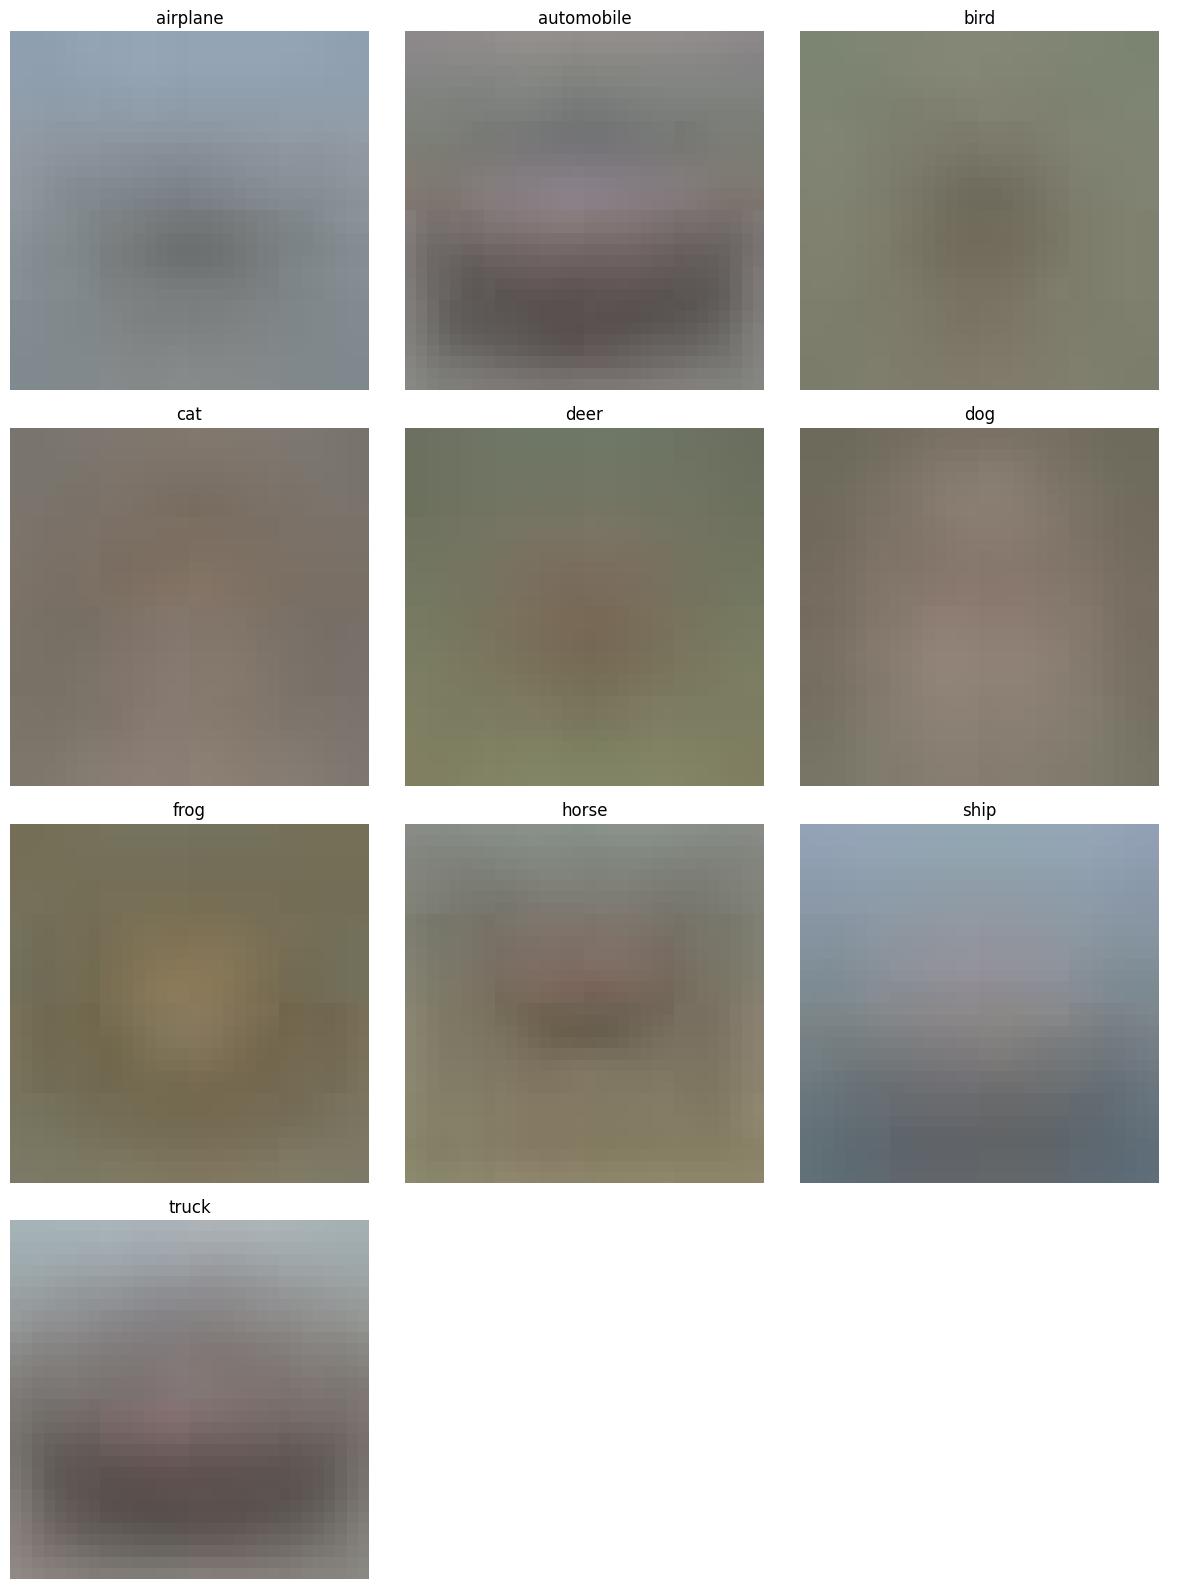

In [ ]:
visualizar_imagenes_destiladas('/content/drive/MyDrive/TFG/image_distilled_08_cifar', cols=3)


### Lenet 01

In [ ]:
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_01_cifar')

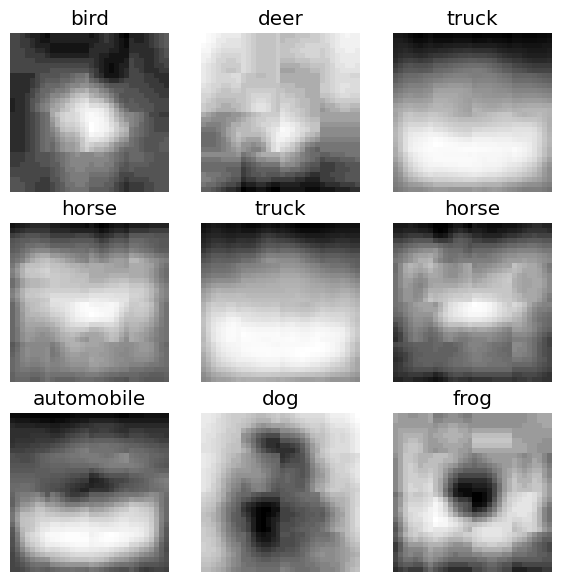

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
  blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
  get_items=get_image_files,
  get_y=parent_label,
  item_tfms=Resize(32),
  splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls_dest = blocks.dataloaders(distilled_path/'train', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls_dest.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Obtener el número total de imágenes
num_train = len(dls_dest.train_ds)
num_valid = len(dls_dest.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls_dest.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 80
Número total de imágenes en validación: 20

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Instanciar el modelo
model = LeNet(num_classes=10)
learn = Learner(dls_dest, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.298222,2.316014,0.150000,0.142857,0.037267,00:30
1,2.298896,2.316549,0.150000,0.142857,0.037267,00:00
2,2.300507,2.317742,0.150000,0.142857,0.037267,00:00
3,2.299986,2.319513,0.150000,0.142857,0.037267,00:00


No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 32.20 segundos


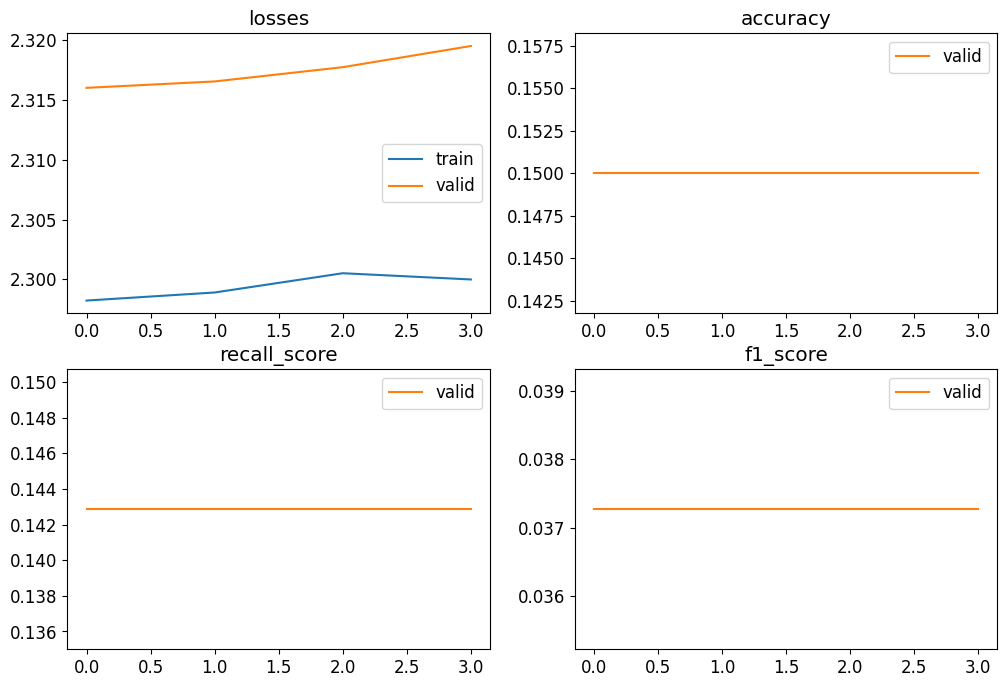

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.3195
Accuracy: 0.1500
Recall: 0.1429
F1-Score: 0.0373


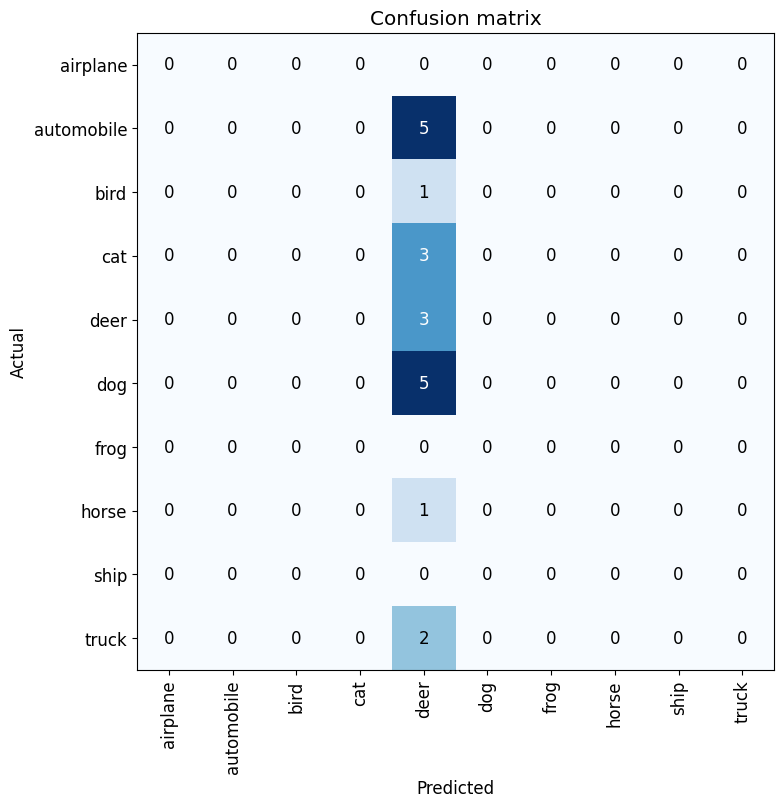

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_01.pkl')

### LENET 001

In [13]:
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_001_cifar')

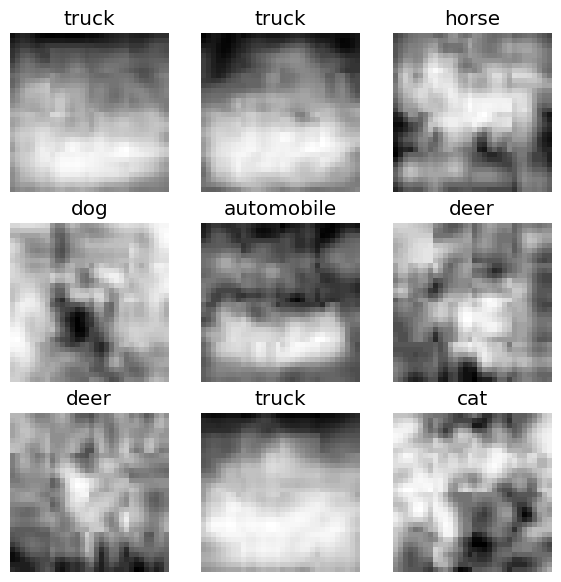

In [14]:
# Crear los DataLoaders
blocks = DataBlock(
  blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
  get_items=get_image_files,
  get_y=parent_label,
  item_tfms=Resize(32),
  splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls_dest = blocks.dataloaders(distilled_path/'train', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls_dest.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Obtener el número total de imágenes
num_train = len(dls_dest.train_ds)
num_valid = len(dls_dest.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls_dest.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 800
Número total de imágenes en validación: 200

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
# Instanciar el modelo
model = LeNet(num_classes=10)
learn = Learner(dls_dest, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [16]:
start_time = time.time()
learn.fit_one_cycle(60)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304765,2.302936,0.090000,0.100000,0.016514,02:39
1,2.304404,2.302418,0.090000,0.100000,0.016514,00:03
2,2.304174,2.302177,0.090000,0.100000,0.016514,00:03
3,2.303508,2.301573,0.100000,0.111111,0.034293,00:03
4,2.302846,2.300658,0.090000,0.100000,0.016514,00:04
5,2.301843,2.296271,0.125000,0.138889,0.045706,00:03
6,2.299707,2.285489,0.180000,0.194737,0.061443,00:03
7,2.292995,2.249661,0.215000,0.223077,0.103336,00:03
8,2.270817,2.108242,0.185000,0.200000,0.062970,00:04
9,2.197798,1.766083,0.285000,0.313194,0.184823,00:03


No improvement since epoch 28: early stopping

Tiempo de entrenamiento: 273.40 segundos


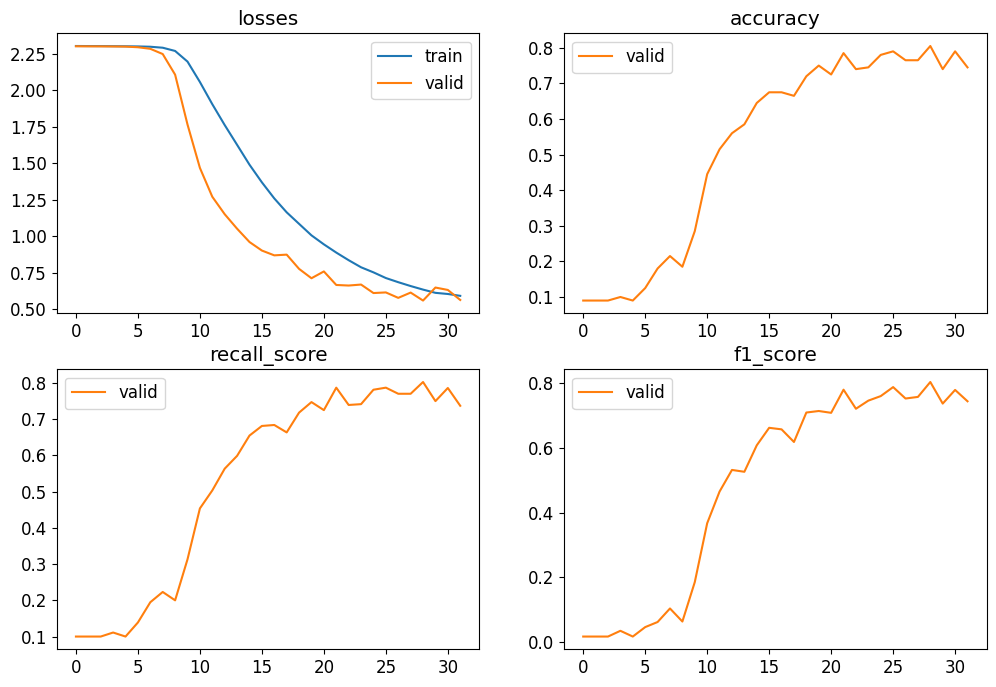

In [17]:
learn.recorder.plot_metrics()

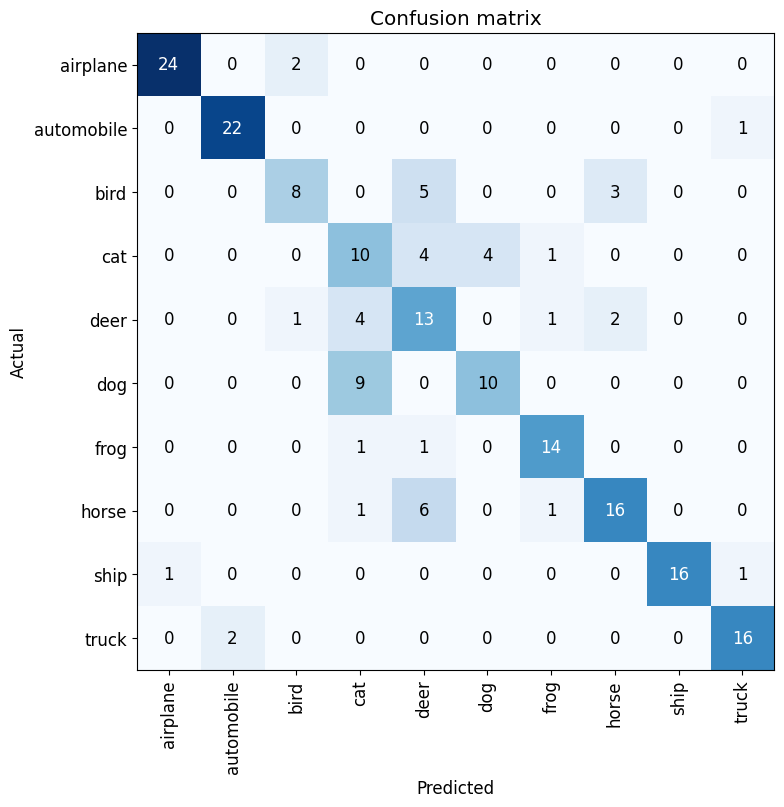

In [18]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [19]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001.pkl')

### Distilled 001

In [ ]:
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_001_cifar')

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  get_y=parent_label,
  item_tfms=Resize(224),
  splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls_dest = blocks.dataloaders(distilled_path/'train', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls_dest.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Obtener el número total de imágenes
num_train = len(dls_dest.train_ds)
num_valid = len(dls_dest.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls_dest.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

In [ ]:
learn2 = vision_learner(dls_dest, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=True)
learn2.fine_tune(10)

In [ ]:
learn2.recorder.plot_metrics()

In [ ]:
#Creamos la interpretación de nuestro learner
interp2 = ClassificationInterpretation.from_learner(learn2)

#Visualizamos la matriz de confusión
interp2.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
interp2.plot_top_losses(15, nrows=5, figsize=(25,18))

In [ ]:
learn2.export('/content/drive/MyDrive/TFG/modelos/resnet18_cifar_distilled_001.pkl')

### Distilled 01

In [ ]:
distilled_path = Path('/content/drive/MyDrive/TFG/image_distilled_01_cifar')

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  get_y=parent_label,
  item_tfms=Resize(224),
  splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls_dest = blocks.dataloaders(distilled_path/'train', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls_dest.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Obtener el número total de imágenes
num_train = len(dls_dest.train_ds)
num_valid = len(dls_dest.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls_dest.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

In [ ]:
learn2 = vision_learner(dls_dest, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=True)
learn2.fine_tune(10)

In [ ]:
learn2.recorder.plot_metrics()

In [ ]:
#Creamos la interpretación de nuestro learner
interp2 = ClassificationInterpretation.from_learner(learn2)

#Visualizamos la matriz de confusión
interp2.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
interp2.plot_top_losses(15, nrows=5, figsize=(25,18))

In [ ]:
learn2.export('/content/drive/MyDrive/TFG/modelos/resnet18_cifar_distilled_001.pkl')

# TEST

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_cifar.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(32),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(dataset_path/'test', bs=256)


In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.4073389768600464
Accuracy: 0.5032051205635071
Recall (macro): 0.5031692571743805
F1 Score (macro): 0.4983771750077678


### 01 distilled

In [22]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(32),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(dataset_path/'test', bs=64)


In [7]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [8]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 10.808075904846191
Accuracy: 0.20522835850715637
Recall (macro): 0.20519397480748588
F1 Score (macro): 0.1807386571575804


### 001 distilled lenet

In [23]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_01.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [24]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.3037402629852295
Accuracy: 0.10126201808452606
Recall (macro): 0.1011
F1 Score (macro): 0.020694418912422217
